In [4]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score
from imblearn.over_sampling import SMOTE


# Prémice : Chargement et création des Dataframes

In [5]:
# On charge le dataset (https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction).
# Attention ! On doit bien faire un répertoire creditCardData avant.
#je voulais prendre automatiquement depuis kaggle le dataset, mais je n'ai pas réussi à le faire,
# je ne sais pas trop pourquoi. Dans tout les cas, je rendrais à dispo le dataset.
application_file_path = 'creditCardData/application_record.csv'
credit_file_path = 'creditCardData/credit_record.csv'

application_data = pd.read_csv(application_file_path)
credit_data = pd.read_csv(credit_file_path)

application_data.head(), application_data.info(), credit_data.head(), credit_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

(        ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
 0  5008804           M            Y               Y             0   
 1  5008805           M            Y               Y             0   
 2  5008806           M            Y               Y             0   
 3  5008808           F            N               Y             0   
 4  5008809           F            N               Y             0   
 
    AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
 0          427500.0               Working               Higher education   
 1          427500.0               Working               Higher education   
 2          112500.0               Working  Secondary / secondary special   
 3          270000.0  Commercial associate  Secondary / secondary special   
 4          270000.0  Commercial associate  Secondary / secondary special   
 
      NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
 0        Civil marriage   Rented apartm

# Features Engineering : recherche de notre target

In [6]:
# On regarde pour chaque ligne de dataframe si on a un retard grave. Un retard grave
# Correspond pour nous à 60 jours ou plus de retard, or dans le dataset à partir de '2'
# Nous sommes à 60 jours de retard.
credit_data['serious_delay'] = credit_data['STATUS'].apply(lambda x: 1 if x in ['2', '3', '4', '5'] else 0)

# On regroupe par ID (pour les "multi comptes") et on regarde si au moins un client à un retard grave.
cpunt = credit_data.groupby('ID')['serious_delay'].apply(lambda x: 1 if 1 in x.values else 0).reset_index()

# On merge nos deux datasets sur "ID" et on créé notre valeur de recherche "target"
new_data = pd.merge(application_data, cpunt, how='inner', on='ID')
new_data['target'] = new_data['serious_delay'].apply(lambda x: 1 if x == 1 else 0)


print(new_data['target'].value_counts())
print(new_data['target'].value_counts(normalize=True))

# Simple fonction d'affichage
def print_final_summary(df):
    print("Shape:", df.shape)
    print("Colonnes:", df.columns.tolist())
    print("head:")
    print(df.head())

print_final_summary(new_data)


target
0    35841
1      616
Name: count, dtype: int64
target
0    0.983103
1    0.016897
Name: proportion, dtype: float64
Shape: (36457, 20)
Colonnes: ['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'serious_delay', 'target']
head:
        ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          4275

# Features Engineering : Ajouts supplémentaires

In [15]:

# On agrège une seconde fois credit_data (perte d'efficacité ?) pour récupérer
# le nombre de mois de crédit total, le retard max du client et le nombre de
# retard trop important du client, pour chaque client.
credit_data_aggregated = credit_data.groupby('ID').agg(
    total_months_with_credit=('MONTHS_BALANCE', 'count'),
    max_delay_status=('STATUS', lambda x: max((int(s) for s in x if isinstance(s, str) and s.isdigit()), default=0)),
    serious_delay_count=('STATUS', lambda x: sum(1 for s in x if s in ['2', '3', '4', '5']))
).reset_index()

new_data = new_data.merge(credit_data_aggregated, on='ID', how='left')

# On récupère l'âge réel de chaque client, ainsi que le nombre d'année d'emploi.
new_data['age'] = -(new_data['DAYS_BIRTH'] // 365)
new_data['years_employed'] = (
    # Si on a x > 0, alors la personne est en recherche d'emploi
    new_data['DAYS_EMPLOYED'].apply(lambda x: 0 if x > 0 else -x // 365)
)

# Suppression des lignes doublons après fusion (normalement inutile si ID est unique dans new_data)
new_data = new_data.drop_duplicates(subset='ID')

#On garde que les colonnes qui nous intéresse.
# On met en commentaire celle-ci car pour max_delay_status, total_months_with_credit
# et serious_delay_count parce que la corrélation entre ces variables et target était supérieur
# à 0.86, ce qui était énorme et "faussait" les résultats des modèles algo.
'''
columns_to_keep = [
    'target', 'CODE_GENDER', 'AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
    'age', 'years_employed', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE','FLAG_OWN_CAR',
    'FLAG_OWN_REALTY','serious_delay_count', 'max_delay_status',
    'total_months_with_credit'
]'''
columns_to_keep = [
    'target', 'CODE_GENDER', 'AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
    'age', 'years_employed', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE','FLAG_OWN_CAR',
    'FLAG_OWN_REALTY','total_months_with_credit'
]

final_data = new_data[columns_to_keep]

# On renomme pour plus de lisibilité
rename_dict = {
    'target': 'target',
    'CODE_GENDER': 'genre',
    'AMT_INCOME_TOTAL': 'revenu_annuel',
    'CNT_CHILDREN': 'nb_enfants',
    'CNT_FAM_MEMBERS': 'taille_famille',
    'age': 'age',
    'years_employed': 'annees_d_emploi',
    'NAME_INCOME_TYPE': 'type_revenu',
    'NAME_EDUCATION_TYPE': 'niveau_education',
    'FLAG_OWN_CAR' : 'Voiture',
    'FLAG_OWN_REALTY' : 'Proprietaire',
    'serious_delay_count': 'nb_retards_serieux',
    'total_months_with_credit': 'mois_de_credit_total',
    'max_delay_status': 'statut_max_retard'
}

final_data = final_data.rename(columns=rename_dict)


print_final_summary(final_data)


print(new_data['target'].value_counts())
print(new_data['target'].value_counts(normalize=True))


Shape: (36457, 12)
Colonnes: ['target', 'genre', 'revenu_annuel', 'nb_enfants', 'taille_famille', 'age', 'annees_d_emploi', 'type_revenu', 'niveau_education', 'Voiture', 'Proprietaire', 'mois_de_credit_total']
head:
   target genre  revenu_annuel  nb_enfants  taille_famille  age  \
0       0     M       427500.0           0             2.0   33   
1       0     M       427500.0           0             2.0   33   
2       0     M       112500.0           0             2.0   59   
3       0     F       270000.0           0             1.0   53   
4       0     F       270000.0           0             1.0   53   

   annees_d_emploi           type_revenu               niveau_education  \
0               12               Working               Higher education   
1               12               Working               Higher education   
2                3               Working  Secondary / secondary special   
3                8  Commercial associate  Secondary / secondary special   
4     

In [9]:
#Fonction qui vérifie les données manquantes.
# N'a servi que pour l'analyse du dataset initiale.
def null_values(df):

    summary = pd.DataFrame({
        'Colonne': df.columns,
        'Valeurs NULL': df.isnull().sum(),
        'Pourcentage NULL (%)': (df.isnull().sum() / len(df)) * 100
    }).sort_values(by='Valeurs NULL', ascending=False)

    print(summary)

null_values(final_data)




                                   Colonne  Valeurs NULL  Pourcentage NULL (%)
target                              target             0                   0.0
genre                                genre             0                   0.0
revenu_annuel                revenu_annuel             0                   0.0
nb_enfants                      nb_enfants             0                   0.0
taille_famille              taille_famille             0                   0.0
age                                    age             0                   0.0
annees_d_emploi            annees_d_emploi             0                   0.0
type_revenu                    type_revenu             0                   0.0
niveau_education          niveau_education             0                   0.0
Voiture                            Voiture             0                   0.0
Proriétaire                    Proriétaire             0                   0.0
mois_de_credit_total  mois_de_credit_total          

# Analyse et visualisation des données

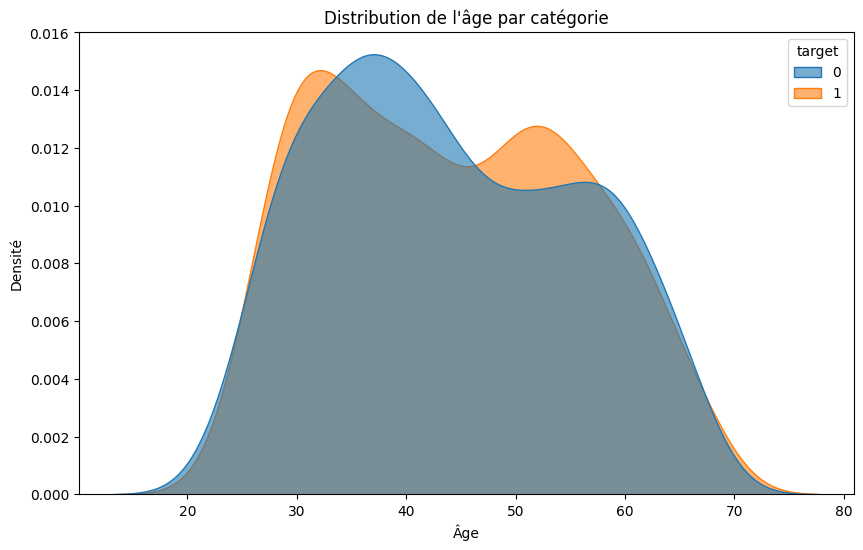

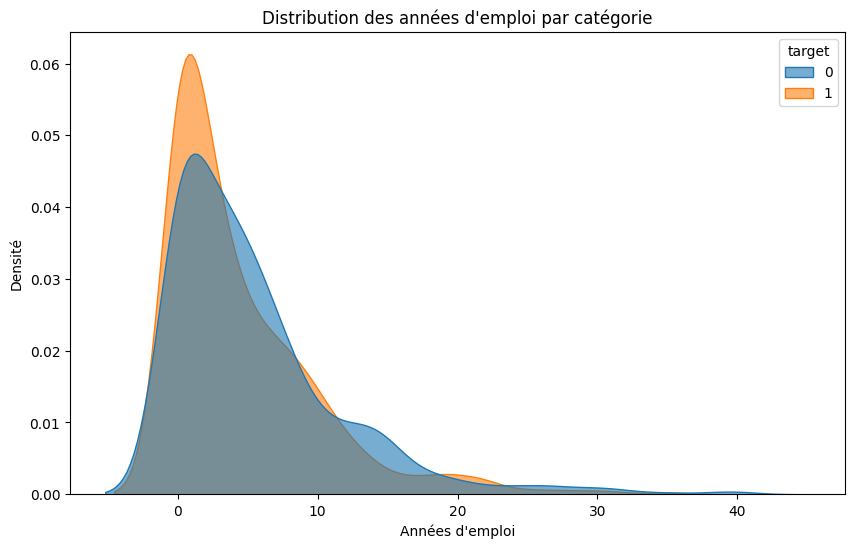

<ipython-input-10-477e5f33ceb9>:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  income_proportions = income_counts.groupby('target').apply(


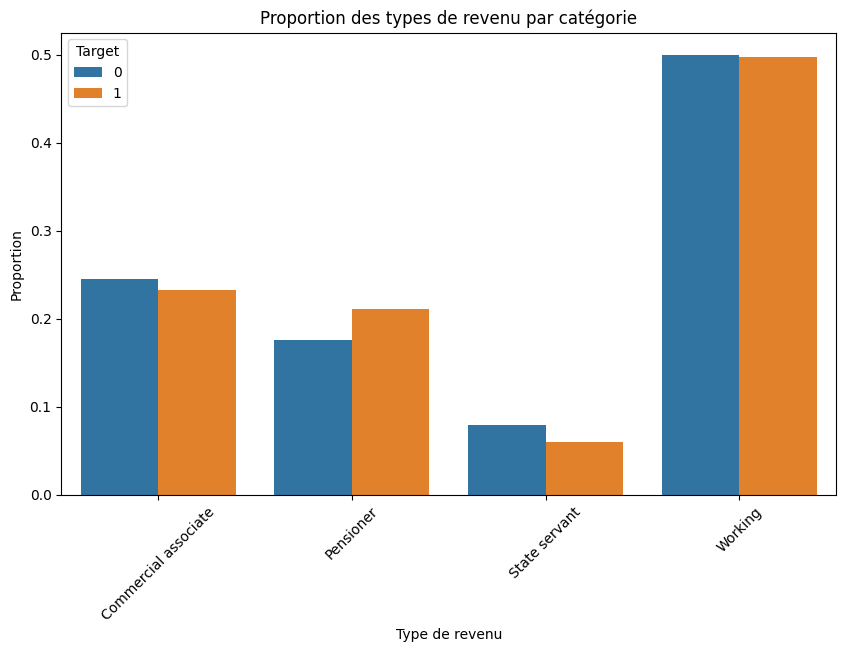

<ipython-input-10-477e5f33ceb9>:100: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  edu_proportions = edu_counts.groupby('target').apply(


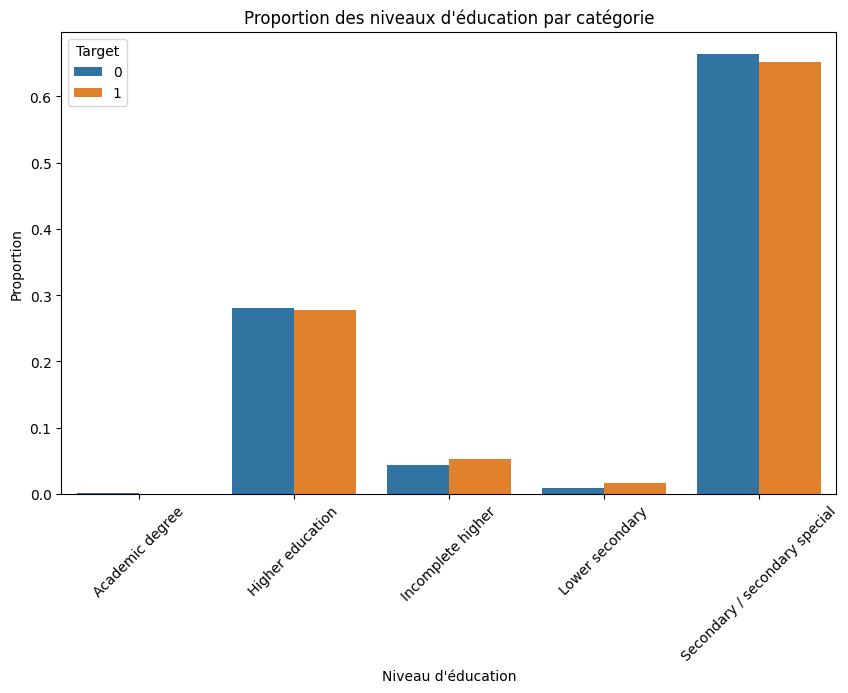

In [10]:
# Fonction de visualisation pour afficher les matrices de confusion sous forme de plot.
def plot_conf_matrix(y_test,y_pred):
  conf_matrix = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Class 0', 'Class 1'],
              yticklabels=['Class 0', 'Class 1'])
  plt.title('Matrice de Confusion')
  plt.xlabel('Prédictions')
  plt.ylabel('Vraies Classes')
  plt.tight_layout()
  plt.show()

# Fonction pour visualiser le resultat des algo
def visualisation_res(dfs_res):
  dfs_res[['Precision', 'Recall']].plot(kind='bar', figsize=(10, 6))
  plt.title('Comparaison des models : avec SMOTE')
  plt.ylabel('Score %')
  plt.xticks(rotation=45)
  plt.legend(loc='lower right')
  plt.tight_layout()
  plt.show()


# Fonction qui affiche un plot des ages en fonction de la classe
def plot_age_by_target(final_data):
    plt.figure(figsize=(10, 6))

    class_counts = final_data['target'].value_counts()
    min_count = class_counts.min()
    balanced_data = pd.concat([
        final_data[final_data['target'] == 0].sample(min_count, random_state=42),
        final_data[final_data['target'] == 1]
    ])

    sns.kdeplot(data=balanced_data, x='age', hue='target', fill=True, alpha=0.6)
    plt.title("Distribution de l'âge par catégorie")
    plt.xlabel("Âge")
    plt.ylabel("Densité")
    plt.show()

plot_age_by_target(final_data)

# Fonction qui affiche le nombre d'années de travail par classe
def plot_employment_years_by_target(final_data):
    plt.figure(figsize=(10, 6))

    class_counts = final_data['target'].value_counts()
    min_count = class_counts.min()
    balanced_data = pd.concat([
        final_data[final_data['target'] == 0].sample(min_count, random_state=42),
        final_data[final_data['target'] == 1]
    ])

    sns.kdeplot(data=balanced_data, x='annees_d_emploi', hue='target', fill=True, alpha=0.6)
    plt.title("Distribution des années d'emploi par catégorie")
    plt.xlabel("Années d'emploi")
    plt.ylabel("Densité")
    plt.show()

plot_employment_years_by_target(final_data)


# Fonction qui affiche le type de revenu par classe
def plot_income_type_by_target(final_data):
    min_count = final_data['target'].value_counts().min()
    balanced_data = pd.concat([
        final_data[final_data['target'] == 0].sample(min_count, random_state=42),
        final_data[final_data['target'] == 1]
    ])

    income_counts = balanced_data.groupby(['target', 'type_revenu']).size().
    reset_index(name='counts')
    income_proportions = income_counts.groupby('target').apply(
        lambda x: x.assign(proportion=x['counts'] / x['counts'].sum())
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=income_proportions,
        x='type_revenu',
        y='proportion',
        hue='target'
    )
    plt.title("Proportion des types de revenu par catégorie")
    plt.xlabel("Type de revenu")
    plt.ylabel("Proportion")
    plt.xticks(rotation=45)
    plt.legend(title="Target")
    plt.show()

plot_income_type_by_target(final_data)

# Fonction qui affiche le niveau d'éducation par classe
def plot_education_level_by_target(final_data):
    min_count = final_data['target'].value_counts().min()
    balanced_data = pd.concat([
        final_data[final_data['target'] == 0].sample(min_count, random_state=42),
        final_data[final_data['target'] == 1]
    ])

    edu_counts = balanced_data.groupby(['target', 'niveau_education']).size().reset_index(name='counts')
    edu_proportions = edu_counts.groupby('target').apply(
        lambda x: x.assign(proportion=x['counts'] / x['counts'].sum())
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=edu_proportions,
        x='niveau_education',
        y='proportion',
        hue='target'
    )
    plt.title("Proportion des niveaux d'éducation par catégorie")
    plt.xlabel("Niveau d'éducation")
    plt.ylabel("Proportion")
    plt.xticks(rotation=45)
    plt.legend(title="Target")
    plt.show()


plot_education_level_by_target(final_data)



# Encodage

In [16]:
# Fonction qui s'occupe de l'encodage. Pour notre encodage, on utilise simplement
# la fonction "get_dummies" de pandas, qui correspond à un encodage one-hot.
def one_hot_encode(df, columns):
    for col in columns:
        one_hot = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, one_hot], axis=1).drop(columns=[col])
    return df

# On encode ces 5 colonnes, car c'est les seuls qui ont besoin d'encodage.
# On remarquera que la traduction des colonnes, qui a été faites juste avant la visualisation,
# aurait du être faites ici ... Mais ce n'est pas grave, on peut quand même comprendre
# les nouvelles colonnes nouvelles formés.
final_data = one_hot_encode(final_data, ['genre', 'type_revenu', 'niveau_education','Voiture','Proprietaire'])

print_final_summary(final_data)

Shape: (36457, 23)
Colonnes: ['target', 'revenu_annuel', 'nb_enfants', 'taille_famille', 'age', 'annees_d_emploi', 'mois_de_credit_total', 'genre_F', 'genre_M', 'type_revenu_Commercial associate', 'type_revenu_Pensioner', 'type_revenu_State servant', 'type_revenu_Student', 'type_revenu_Working', 'niveau_education_Academic degree', 'niveau_education_Higher education', 'niveau_education_Incomplete higher', 'niveau_education_Lower secondary', 'niveau_education_Secondary / secondary special', 'Voiture_N', 'Voiture_Y', 'Proprietaire_N', 'Proprietaire_Y']
head:
   target  revenu_annuel  nb_enfants  taille_famille  age  annees_d_emploi  \
0       0       427500.0           0             2.0   33               12   
1       0       427500.0           0             2.0   33               12   
2       0       112500.0           0             2.0   59                3   
3       0       270000.0           0             1.0   53                8   
4       0       270000.0           0            

# Modèle sans SMOTE



Train Random Forest...


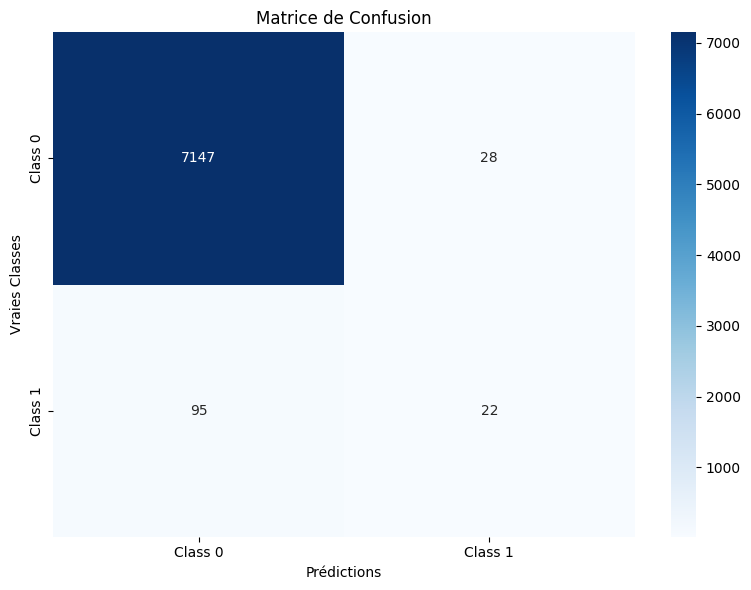


Train Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


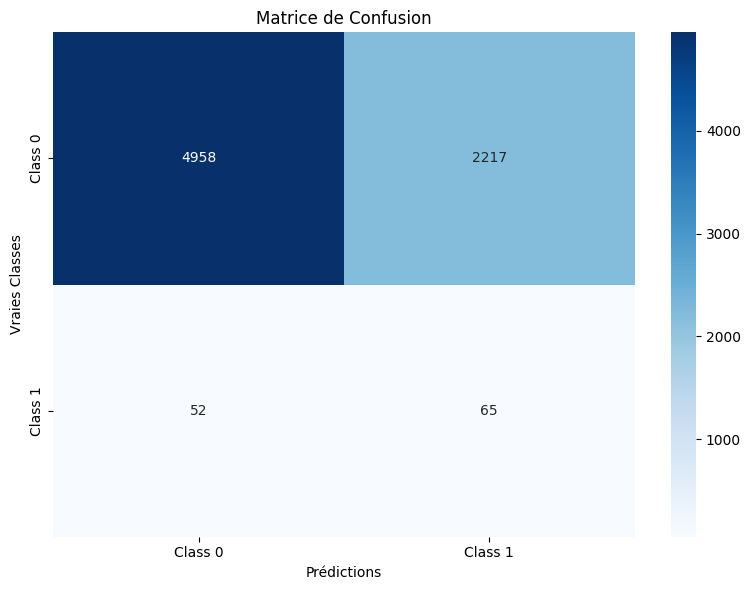


Train SVM...


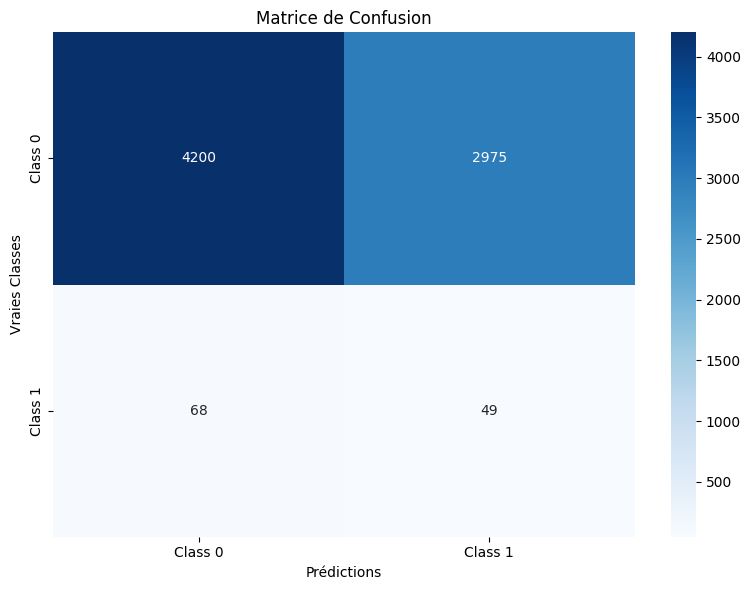


Train k-NN...


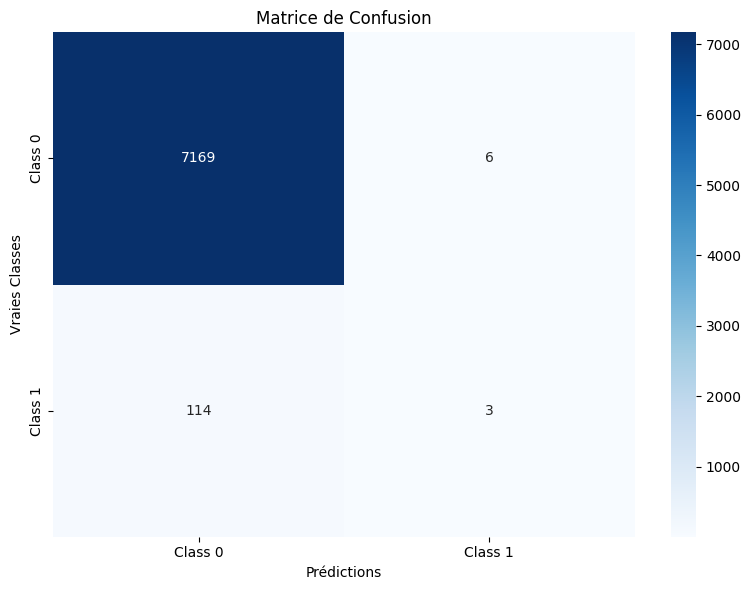


Resultats :
                     Precision    Recall
Random Forest         0.440000  0.188034
Logistic Regression   0.028484  0.555556
SVM                   0.016204  0.418803
k-NN                  0.333333  0.025641


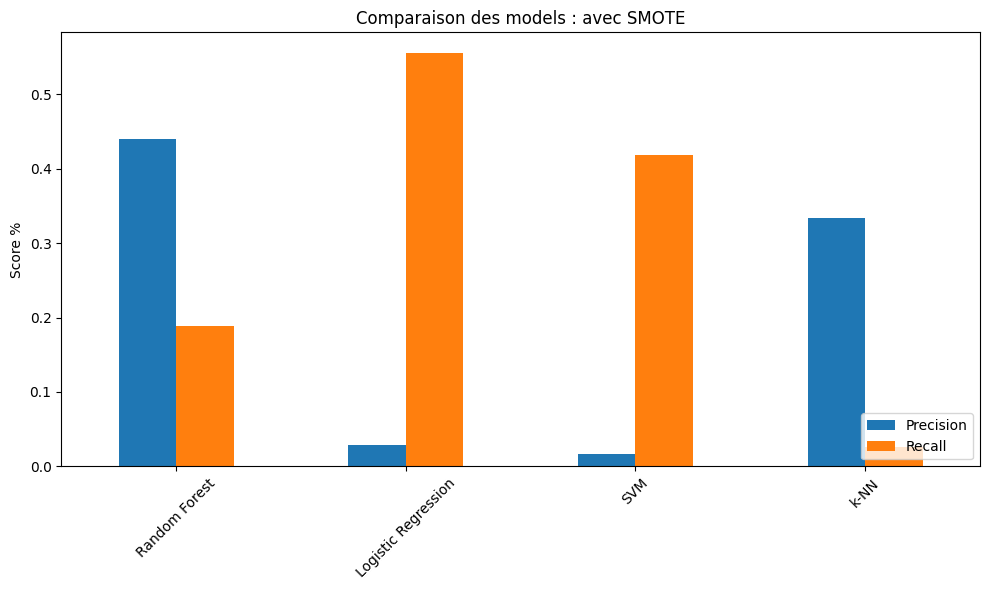

In [19]:
''' Avec nos données traités, on peut désormais appliquer nos algorithmes.
Cependant, notre dataset est TRES déséquilibré. C'est pourquoi j'ai décidé de
faire deux versions différentes de l'application des algorithmes. Cette première version
n'utilise pas l'algorithme SMOTE qui permet d'ajuster le dataset en  équilibrant
nos classes, pour voir ce que cela rendrait sans l'algorithme.
'''
X = final_data.drop(columns=['target'])
y = final_data['target']


# On coupe le dataset en deux, X et Y, en faisant 50/50
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


# On initialise nos models. On prendra 4 modèles de classification (vu en cours):
# Random Forest, Log Reg, SVM, et le k-NN. Pourquoi ? Algorithmes vu en cours,
# que je voulais tester, et qui me semble intéressant à voir
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'SVM': SVC(random_state=42,kernel="rbf",class_weight='balanced', probability=True),
    'k-NN': KNeighborsClassifier()
}

results = {}

# Pour chaque model, on applique le training etc...
for name, model in models.items():
    print(f"\nTrain {name}...")

    model.fit(X_train, y_train)

    # Evalue sur test
    y_pred = model.predict(X_test)

    # Calcul du recall et de la precision
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    plot_conf_matrix(y_test,y_pred)

    results[name] = {
        'Precision': precision,
        'Recall': recall,
    }

results_df = pd.DataFrame(results).T
print("\nResultats :")
print(results_df)

# Visualisation des résultats
visualisation_res(results_df)





# Modèles avec SMOTE

features trop corrélés: ['target']

Train Random Forest...


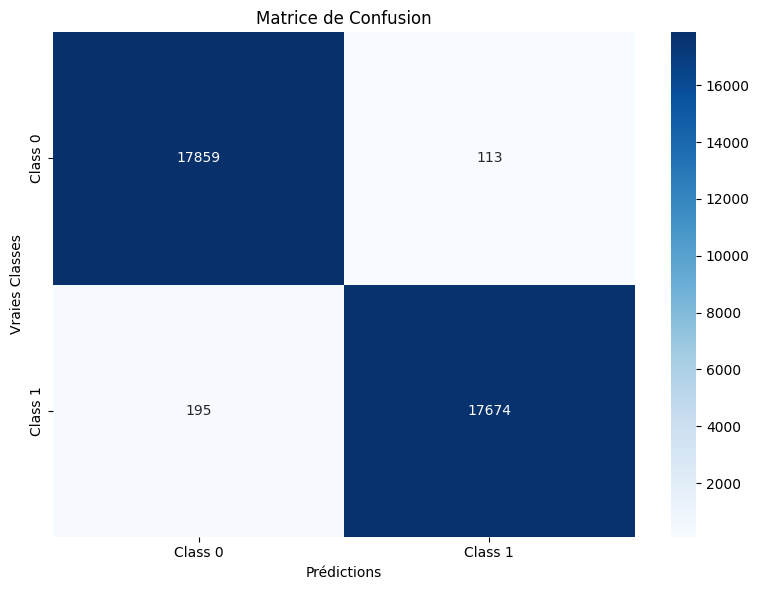


Train Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


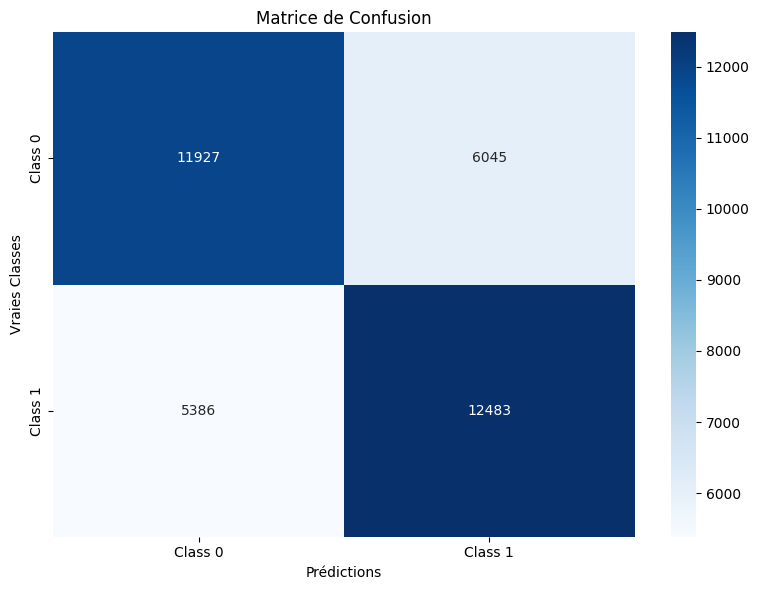


Train SVM...


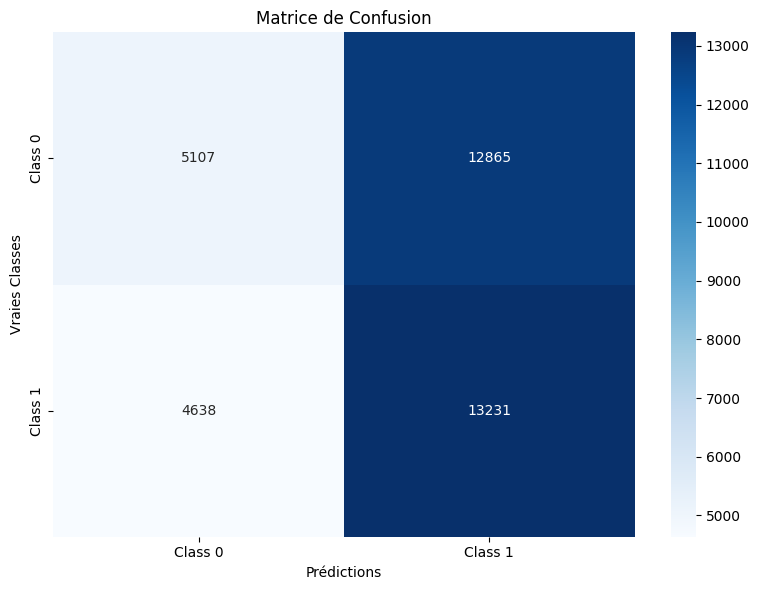


Train k-NN...


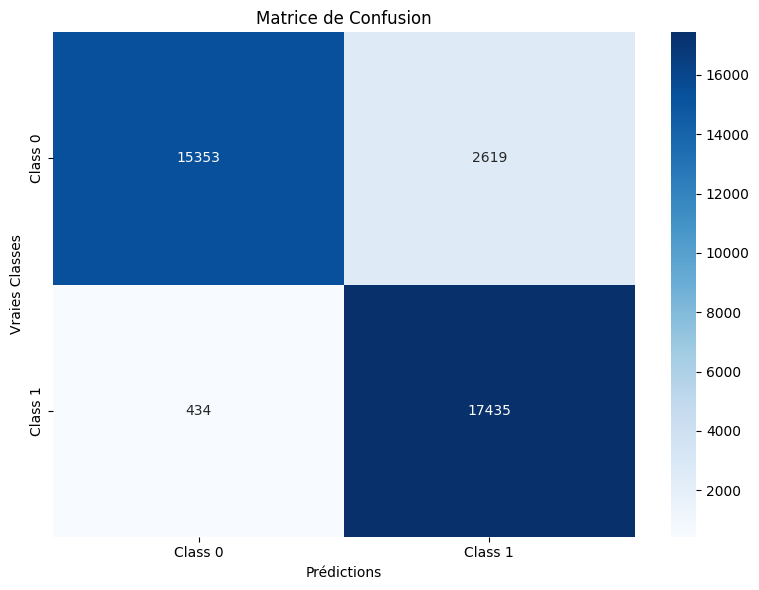


Resultats :
                     Precision     Recall
Random Forest        99.364705  98.908725
Logistic Regression  67.373705  69.858414
SVM                  50.701257  74.044434
k-NN                 86.940261  97.571213


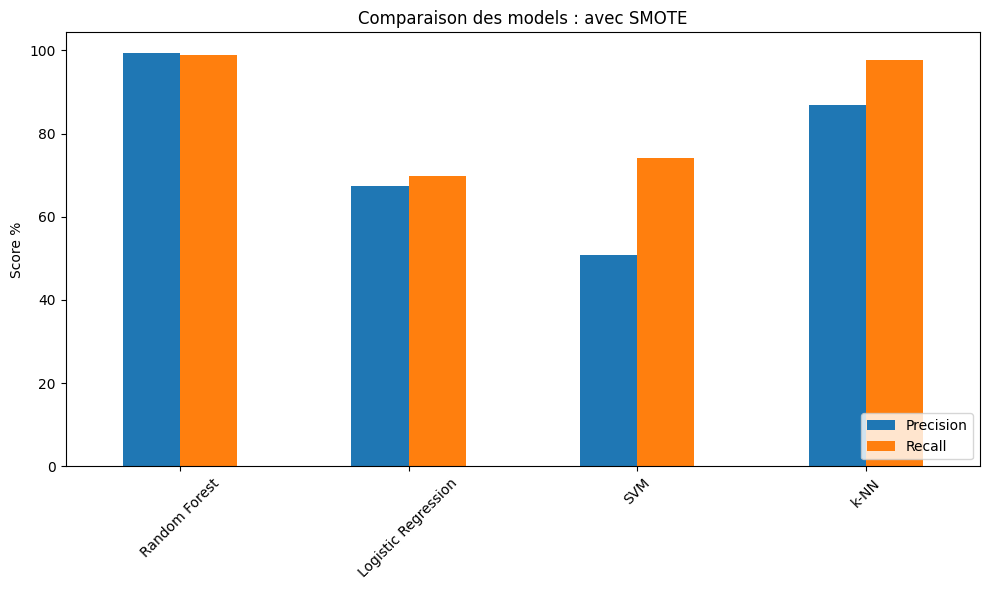

In [18]:
''' Version cette fois en utilisant l'algorithme SMOTE. L'algorithme SMOTE '''

# On retire les features qui sont trop correlés à target. Pourquoi ?
# Quand j'ai effectué la première version des algos, j'ai obtenu un recall et précision
# de 100% sur 3 des 4 algos, ce qui faisait que les classifieurs étaient parfait (même
# sans utiliser SMOTE). Les 3 colonnes trop corrélé à target sont maintenant en commentaire
# dans le code des features, et j'avais obtenu une correlation de plus de 86%, ce qui est énorme.
# De plus, ces features étaient uniquement obtenu à partir de la table credit_record, ce qui faisait
# qu'il n'y avait quasi pas d'intérêt d'utiliser application_record.
correlations = pd.concat([X, y], axis=1).corr()
high_corr_features = correlations.index[abs(correlations['target']) > 0.50].tolist()
print("features trop corrélés:", high_corr_features)


X_cleaned = X.drop(columns=[col for col in high_corr_features if col != 'target'])

# Rééquilibrage des données en utilisant l'algorithme SMOTE
smote = SMOTE(random_state=94)
X_resampled, y_resampled = smote.fit_resample(X_cleaned, y)


# Séparation du model en X Y.
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


# Pour chaque model, on applique le training etc...
models = {
    'Random Forest': RandomForestClassifier(random_state=420),
    'Logistic Regression': LogisticRegression(random_state=4200, class_weight='balanced'),
    'SVM': SVC(random_state=320, class_weight='balanced', probability=True),
    'k-NN': KNeighborsClassifier()
}

results = {}

for name, model in models.items():
    print(f"\nTrain {name}...")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred) * 100
    recall = recall_score(y_test, y_pred) * 100

    plot_conf_matrix(y_test,y_pred)

    results[name] = {
        'Precision': precision,
        'Recall': recall
    }

results_df = pd.DataFrame(results).T
print("\nResultats :")
print(results_df)

# Visualisation des résultats
visualisation_res(results_df)



